In [ ]:
import pandas as pd

In [ ]:
df_train= pd.read_csv('/content/drive/MyDrive/TP5_Data/cars_train_data.csv')

In [ ]:
df_train.head()

,Unnamed: 0,x1,y1,x2,y2,Class,image
0,0,39,116,569,375,14,00001.jpg
1,1,36,116,868,587,3,00002.jpg
2,2,85,109,601,381,91,00003.jpg
3,3,621,393,1484,1096,134,00004.jpg
4,4,14,36,133,99,106,00005.jpg


In [ ]:
data_directory = "/content/drive/MyDrive/TP5_Data"
train_images = "/content/drive/MyDrive/TP5_Data/cars_train"

# Redimensionner des images avec PyTorch

In [ ]:
import os
from PIL import Image
from torchvision import transforms

# needed input dimensions for the CNN
input_dim = (224,224)
input_dir_cnn = data_directory + "/images/input_images_cnn"

os.makedirs(input_dir_cnn, exist_ok = True)

transformation_for_cnn_input = transforms.Compose([transforms.Resize(input_dim)])

for image_name in os.listdir(train_images):
  I = Image.open(os.path.join(train_images, image_name))
  newI = transformation_for_cnn_input(I)

  newI.save(os.path.join(input_dir_cnn, image_name))

  newI.close()
  I.close()

# **Creer la classe C**

In [ ]:
import torch
from torchvision import models
#from torchvision import transforms

class Img2VecResnet18():
    def __init__(self):
        self.device = torch.device("cpu")
        self.numberFeatures = 512
        self.modelName = "resnet-18"
        self.model, self.featureLayer = self.getFeatureLayer()
        self.model = self.model.to(self.device)
        self.model.eval()
        self.toTensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                              std=[0.229, 0.224, 0.225])

    def getFeatureLayer(self):
        cnnModel = models.resnet18(pretrained=True)
        layer = cnnModel._modules.get('avgpool')
        self.layer_output_size = 512
        return cnnModel, layer

    def getVec(self, img):
        image = self.normalize(self.toTensor(img)).unsqueeze(0).to(self.device)
        embedding = torch.zeros(1, self.numberFeatures, 1, 1)
        def copyData(m, i, o):
            embedding.copy_(o.data)
        h = self.featureLayer.register_forward_hook(copyData)
        self.model(image)
        h.remove()
        return embedding.numpy()[0, :, 0, 0]

# **En utilisant la classe c, calculer les images embeddings de toutes les images**

In [ ]:
#import tqdm
from tqdm.notebook import tqdm

img2vec = Img2VecResnet18()
allVectors = {}
for image in tqdm(os.listdir(input_dir_cnn)):
  I = Image.open(os.path.join(input_dir_cnn, image))
  vec = img2vec.getVec(I)
  allVectors[image] = vec
  I.close()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 77.0MB/s]


  0%|          | 0/100 [00:00<?, ?it/s]

# **Stocker les images embeddings dans un fichier csv**

In [ ]:
import pandas as pd
pd.DataFrame(allVectors).transpose().\
to_csv(data_directory + '/input_data_vectors.csv')

In [ ]:
! pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=56b18c812667664336be47f11fbb3a9f9787d0a601a89beebc55195f28653409
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


# **creer un dataframe spark qui contient les images embeddings**

In [ ]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("tp5").getOrCreate()
input_df = spark.read.option("header", "true").option('inferSchema', True).\
csv(data_directory + '/input_data_vectors.csv')

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


L'implémentation LSH de PySpark nécessite une colonne vecteur (vector column) en
entrée. Effectuer une transformation pour représenter les colonnes pertinentes par un seul
vecteur.

In [ ]:
from pyspark.ml.feature import VectorAssembler
vector_columns = input_df.columns[1:]
assembler = VectorAssembler(inputCols=vector_columns, outputCol="features")
output = assembler.transform(input_df)
output = output.select('_c0', 'features')

In [ ]:
output.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- features: vector (nullable = true)



# **Creer un modele en utilisant le BucketedRandomProjection**

In [ ]:
from pyspark.ml.feature import BucketedRandomProjectionLSH
brp = BucketedRandomProjectionLSH(inputCol="features", outputCol="hashes",
numHashTables=200, bucketLength=2.0)
model = brp.fit(output)

Transformer le DataFrame à l'aide du modèle LSH nouvellement créé. Le DataFrame
résultant contiendra une colonne de hachage contenant une représentation hachée des images
embeddings.

In [ ]:
lsh_df = model.transform(output)
lsh_df.show(5, False)

+---------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

# **Choisissez une image aléatoire.**

/content/drive/MyDrive/TP5_Data/images/input_images_cnn/00023.jpg


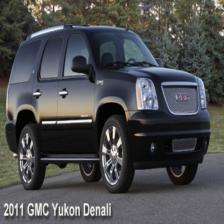

In [ ]:
from IPython.display import display
from PIL import Image

input_dir_cnn = data_directory + "/images/input_images_cnn"

test_image = os.listdir(input_dir_cnn)[0]
test_image = os.path.join(input_dir_cnn, test_image)
print(test_image)
display(Image.open(test_image))

# **Convertir cette image dans un format vectoriel.**

In [ ]:
img2vec = Img2VecResnet18()
I = Image.open(test_image)
test_vec = img2vec.getVec(I)
I.close()

#print(len(test_vec))
#print(test_vec)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
from pyspark.ml.linalg import Vectors
test_vector = Vectors.dense(test_vec)
print(test_vector)

[1.113511562347412,1.1935672760009766,1.0748142004013062,0.12238124758005142,2.5405521392822266,0.48329800367355347,1.1345733404159546,0.29221969842910767,1.365686058998108,0.8065996766090393,0.2560294270515442,0.30876240134239197,0.01600889302790165,3.1214776039123535,0.10804631561040878,0.5206397771835327,0.21423575282096863,0.8384332656860352,0.03599162399768829,0.18484091758728027,0.8374549746513367,3.4506661891937256,0.6639813780784607,0.1908302903175354,1.092591643333435,1.3475124835968018,1.4854297637939453,3.9153635501861572,0.623389720916748,0.6074156165122986,0.0016545162070542574,0.0665508508682251,0.5924047231674194,0.25297045707702637,0.019078971818089485,0.3585242033004761,0.1492195576429367,1.8035944700241089,0.597874641418457,0.38223910331726074,0.5611129999160767,0.854884147644043,0.31107181310653687,1.6125538349151611,0.619681179523468,0.7511121034622192,0.7821565866470337,0.10806640237569809,0.46198606491088867,0.3766043782234192,0.7010311484336853,0.4843125939369201

# **Effectuer une recherche approximative des cinq plus proches**

In [ ]:
print("Approximately searching lsh_df for 5 nearest neighbors \
of input vector:")
result = model.approxNearestNeighbors(lsh_df, test_vector, 5)
result.show()

Approximately searching lsh_df for 5 nearest neighbors of input vector:
+---------+--------------------+--------------------+--------------------+
|      _c0|            features|              hashes|             distCol|
+---------+--------------------+--------------------+--------------------+
|00023.jpg|[1.1135116,1.1935...|[[0.0], [0.0], [0...|4.765181684795851E-7|
|00052.jpg|[0.6169595,1.8989...|[[0.0], [0.0], [0...|   9.545319284626244|
|00077.jpg|[0.85670733,1.940...|[[0.0], [0.0], [0...|   9.704154830499132|
|00028.jpg|[0.8576984,1.0628...|[[0.0], [0.0], [0...|   10.26567235029635|
|00012.jpg|[0.6537362,1.1377...|[[0.0], [1.0], [0...|  11.053064735067412|
+---------+--------------------+--------------------+--------------------+



# **Afficher les images qui correspondent aux cinq voisins**

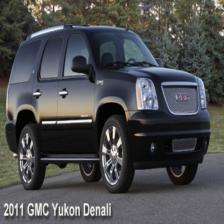

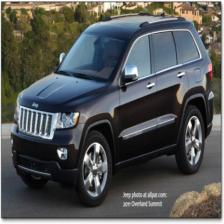

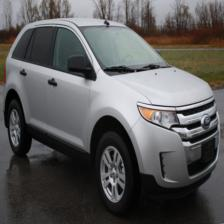

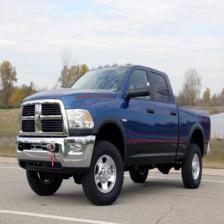

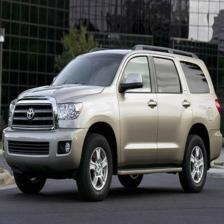

In [ ]:
for i in list(result.select('_c0').toPandas()['_c0']):
  display(Image.open(os.path.join(input_dir_cnn, i)))